# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
import os

import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns


import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE



In [29]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels


from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import matplotlib.pyplot as plt

# Data

In [2]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


torch.set_default_dtype(torch.float32)

In [3]:
Device = 'cpu'

# L.GP

In [4]:
row_idx = 0
input_point = test_y_21[row_idx, :]

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=500)

In [10]:
LocalGP_models, LocalGP_likelihoods = Training.train_one_row_LocalGP_Parallel(
    train_x, train_y_21, test_y_21, row_idx,
    covar_type='RBF', k_num=500, lr=0.025,
    num_iterations=5000, patience=50, device=Device
)

# Parameter Inference

In [6]:
bounds = bound.get_bounds(local_train_x)

## point estimation

In [11]:
estimated_params_tmp, _ = Estimation.multi_start_estimation(
    LocalGP_models, LocalGP_likelihoods, row_idx, test_y_21, bounds,
    Estimation.estimate_params_Adam, num_starts=16, num_iterations=2000, lr=0.01,
    patience=50, attraction_threshold=0.1, repulsion_strength=0.1, device=Device
)

In [12]:
estimated_params_tmp

array([3.9336088 , 4.015037  , 1.5426767 , 4.344546  , 3.0147772 ,
       0.43047747, 3.5031142 , 2.3710794 , 4.954913  , 1.4800527 ],
      dtype=float32)

In [9]:
test_x[row_idx]

tensor([3.6700, 4.8642, 1.4330, 4.7406, 2.8699, 0.6171, 3.0394, 3.4495, 4.7810,
        1.8129])

## MCMC

In [23]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC


def run_mcmc_uniform_independent(
    Pre_function,
    models,                     # list[gp.Model]
    likelihoods,                # list[gpytorch.likelihoods.*]
    output_slices,              # list[slice | list[int] | torch.LongTensor]
    row_idx,                    # int | list[int] | torch.LongTensor
    test_y,                     # Tensor[ n_rows , n_outputs ]
    bounds,                     # list[ (low, high) ]
    num_samples = 2_000,
    warmup_steps = 1_000,
    num_chains = 1,
    device = "cpu",
    dtype=torch.float32,
):

    test_y = test_y.to(dtype=dtype, device=device)


    bounds_t = [
        (torch.tensor(lo, dtype=dtype, device=device),
         torch.tensor(hi, dtype=dtype, device=device))
        for lo, hi in bounds
    ]
    n_params = len(bounds_t)

    def model():

        theta = torch.stack([
            pyro.sample(f"param_{i}", dist.Uniform(lo, hi))
            for i, (lo, hi) in enumerate(bounds_t)
        ])


        for k, (mdl, lkhd, cols) in enumerate(zip(models, likelihoods, output_slices)):

            gp_pred_k = Pre_function(mdl, lkhd, theta.unsqueeze(0))


            y_obs_k = test_y[row_idx][cols]

            pyro.sample(f"obs_{k}", gp_pred_k, obs=y_obs_k)


    nuts_kernel = NUTS(model)

    # if initial_params is not None:
    #     initial_params_dict = {
    #         f"param_{i}": torch.as_tensor(p, dtype=dtype, device=device)
    #         for i, p in enumerate(initial_params)
    #     }

    mcmc = MCMC(
        nuts_kernel,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
        num_chains=num_chains
        # initial_params=initial_params_dict,
    )
    mcmc.run()

    return mcmc


In [24]:
output_slices = [[i] for i in range(len(LocalGP_models))] 
# output_slices = [slice(0, 2), slice(2, 4), slice(4, 6)]

mcmc_result = run_mcmc_uniform_independent(
    Prediction.preds_distribution_fast_pred_var, LocalGP_models, LocalGP_likelihoods, output_slices,
    row_idx, test_y_21, bounds, 
    num_samples=1500, warmup_steps=500, num_chains=1, device=Device
    )

Sample: 100%|██████████| 2000/2000 [1:20:54,  2.43s/it, step size=5.65e-02, acc. prob=0.438]


In [25]:
samples_1 = mcmc_result.get_samples()

torch.save(samples_1, "LGP_mcmc_samples.pt")

param_0: R-hat = 1.485, split R-hat = 2.508, ESS = 2.5


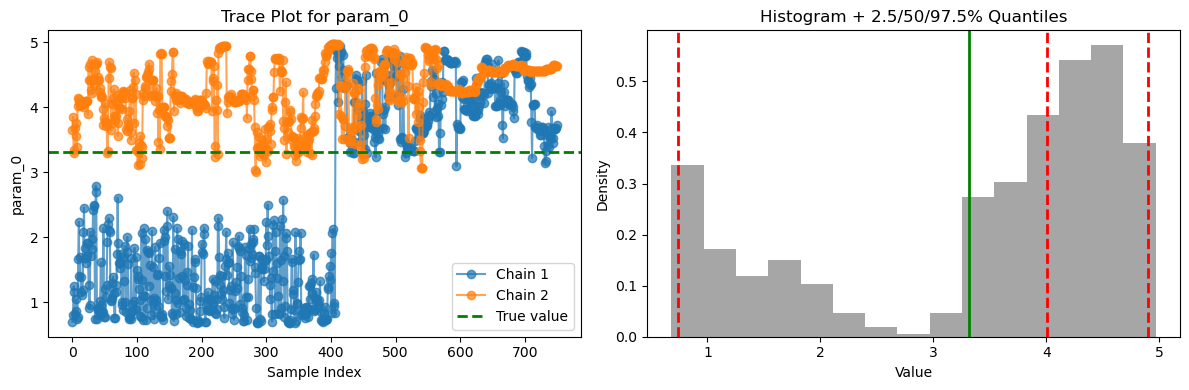

<Figure size 600x400 with 0 Axes>

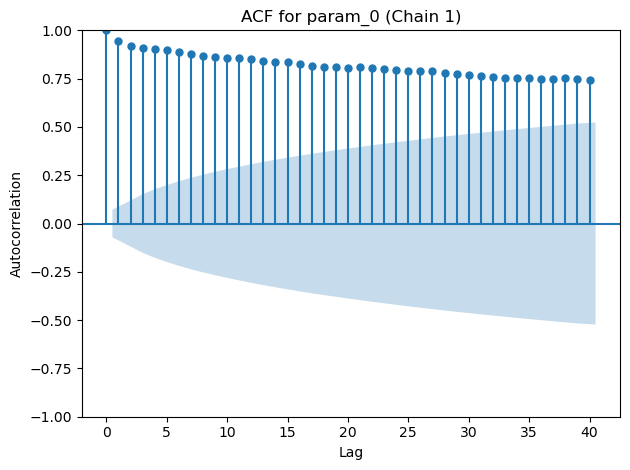

param_1: R-hat = 1.152, split R-hat = 1.653, ESS = 5.9


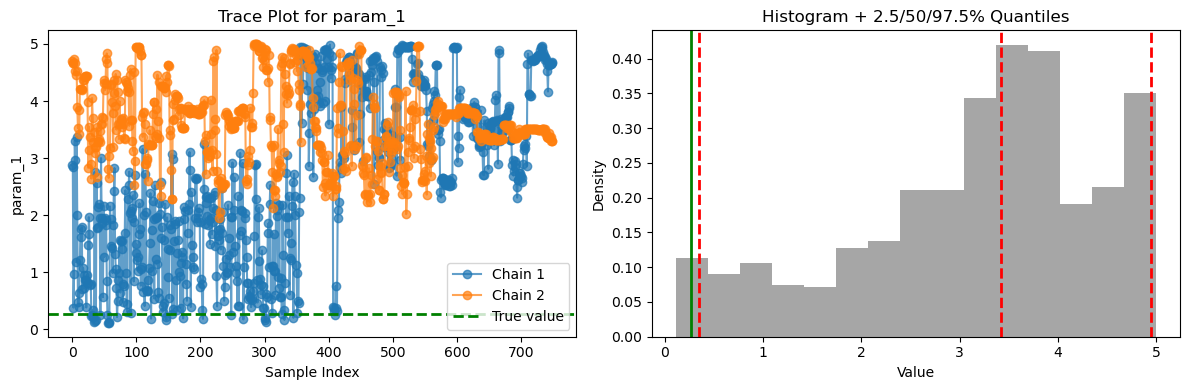

<Figure size 600x400 with 0 Axes>

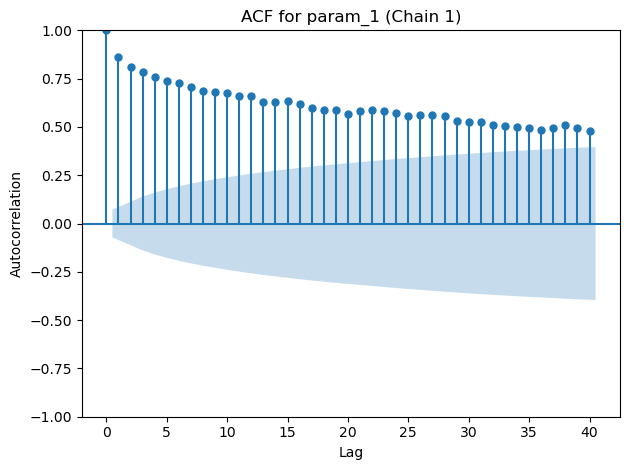

Warmup:   0%|          | 0/2000 [1:57:16, ?it/s]

param_2: R-hat = 1.209, split R-hat = 1.427, ESS = 5.4


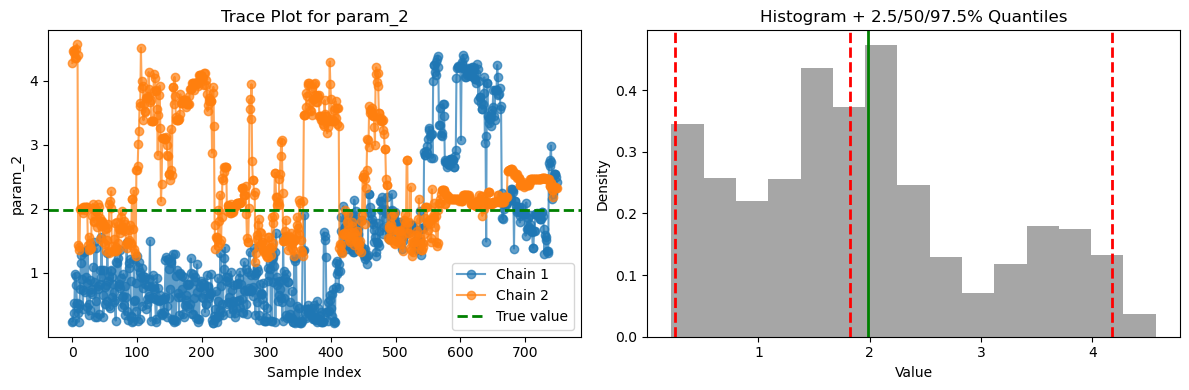

<Figure size 600x400 with 0 Axes>

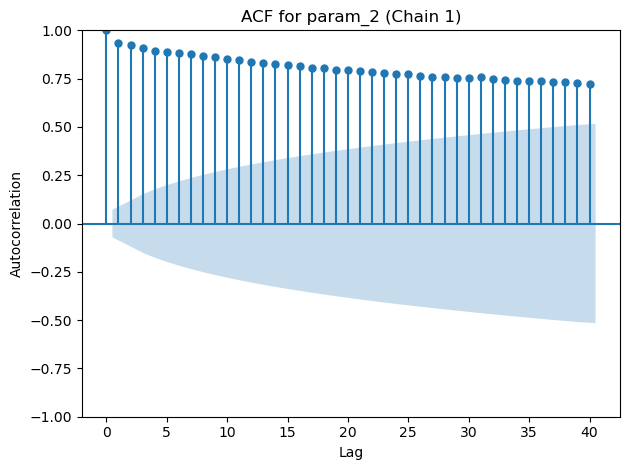

param_3: R-hat = 1.049, split R-hat = 1.142, ESS = 21.9


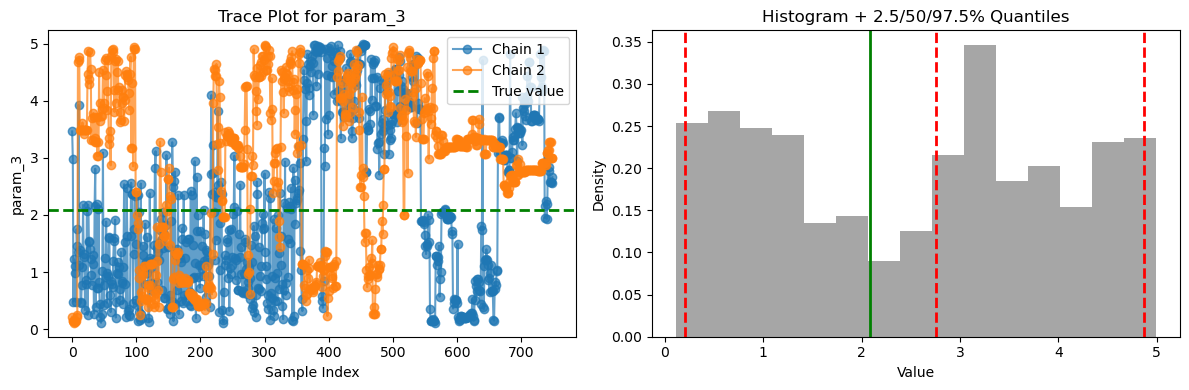

<Figure size 600x400 with 0 Axes>

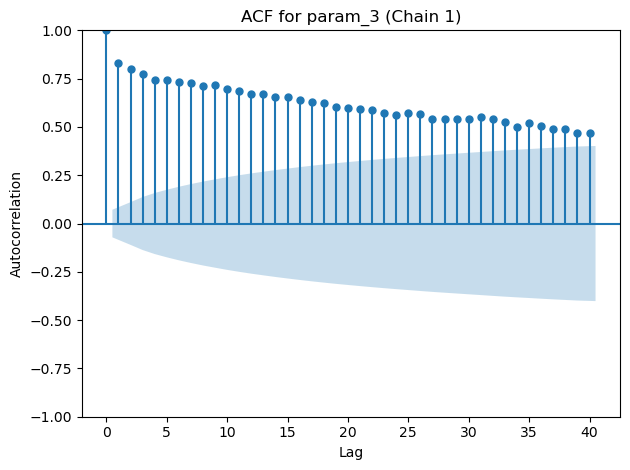

param_4: R-hat = 1.292, split R-hat = 1.961, ESS = 4.0


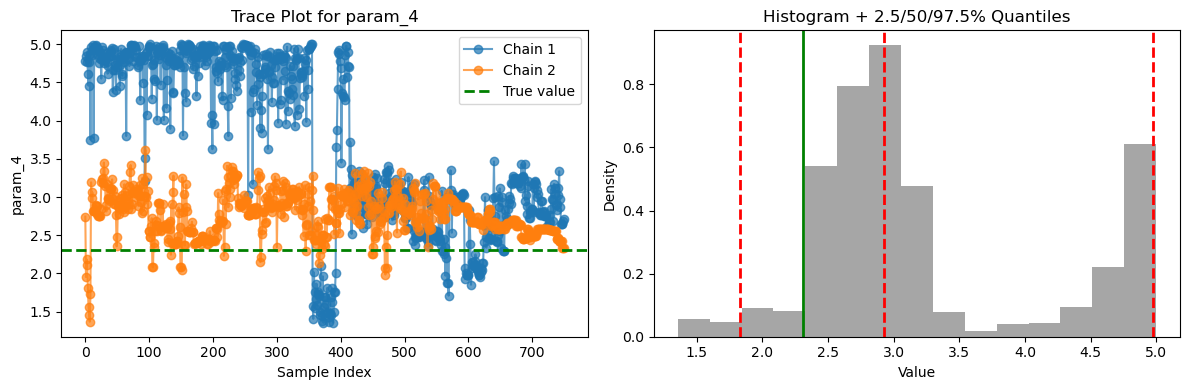

<Figure size 600x400 with 0 Axes>

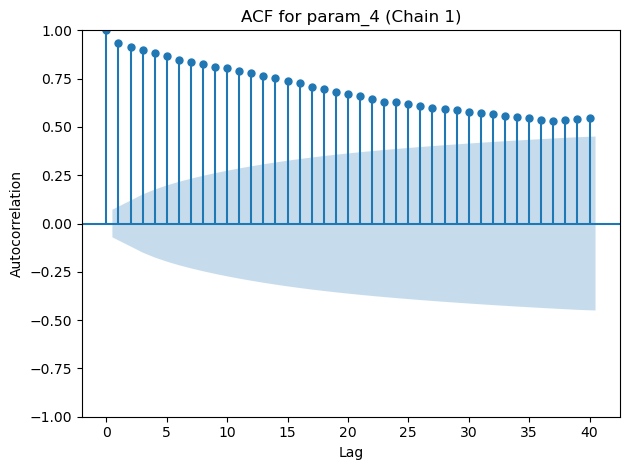

param_5: R-hat = 1.410, split R-hat = 3.715, ESS = 3.2


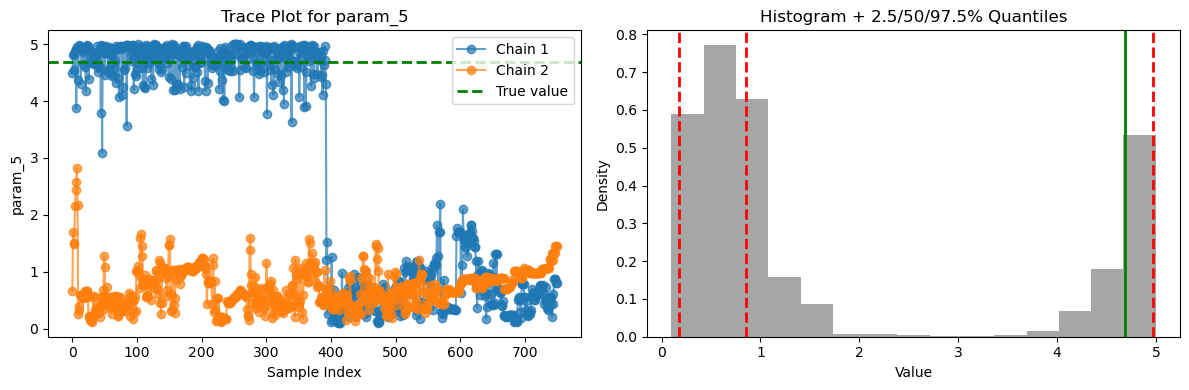

<Figure size 600x400 with 0 Axes>

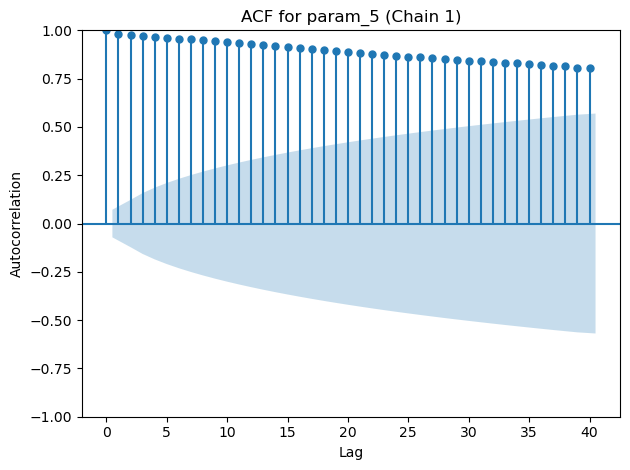

param_6: R-hat = 1.247, split R-hat = 1.467, ESS = 4.7


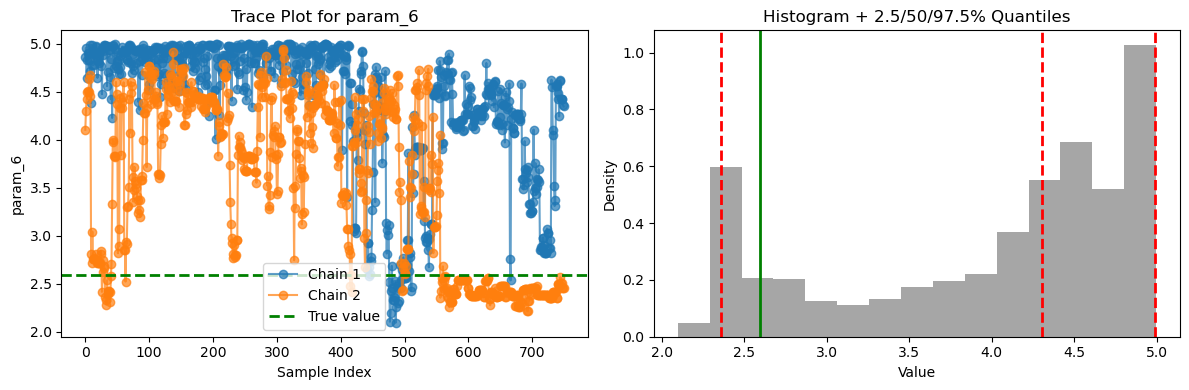

<Figure size 600x400 with 0 Axes>

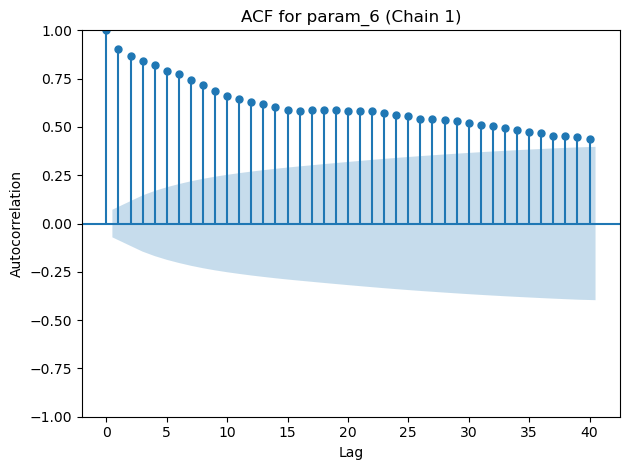

param_7: R-hat = 1.070, split R-hat = 1.428, ESS = 7.2


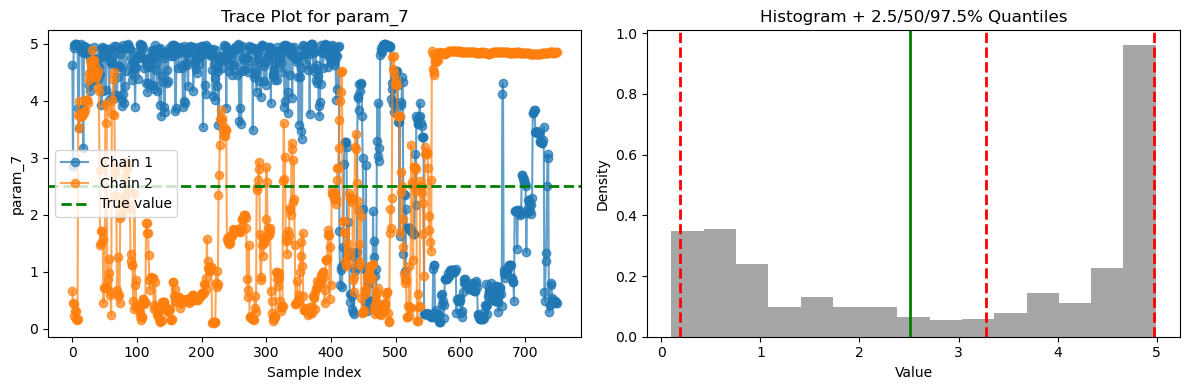

<Figure size 600x400 with 0 Axes>

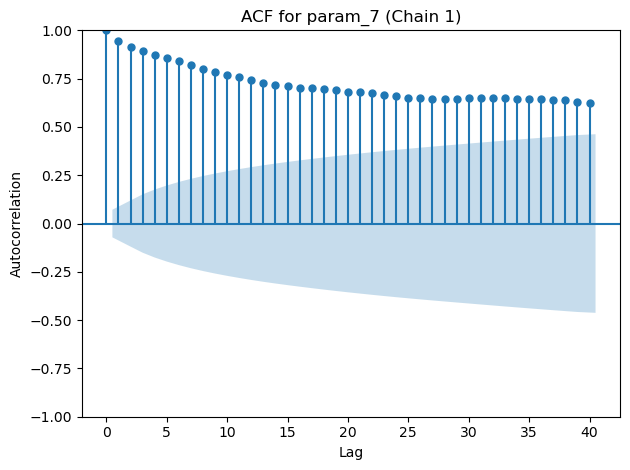

param_8: R-hat = 1.020, split R-hat = 1.741, ESS = 6.7


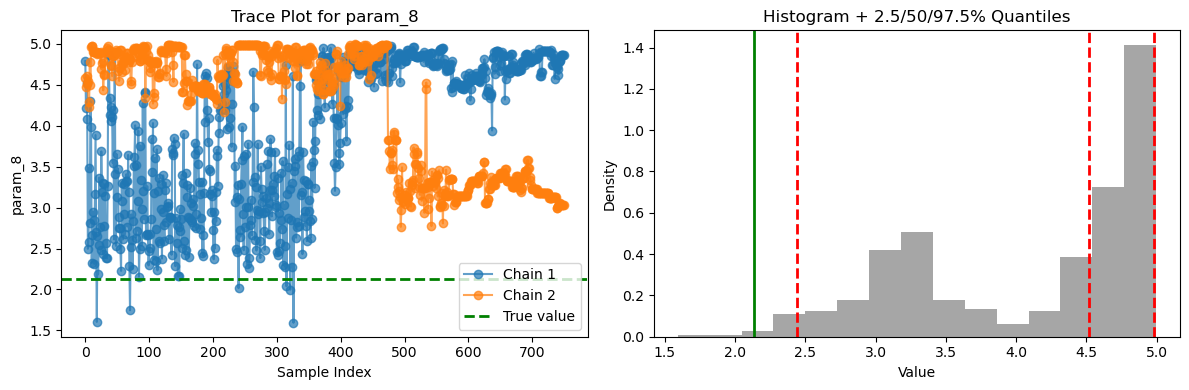

<Figure size 600x400 with 0 Axes>

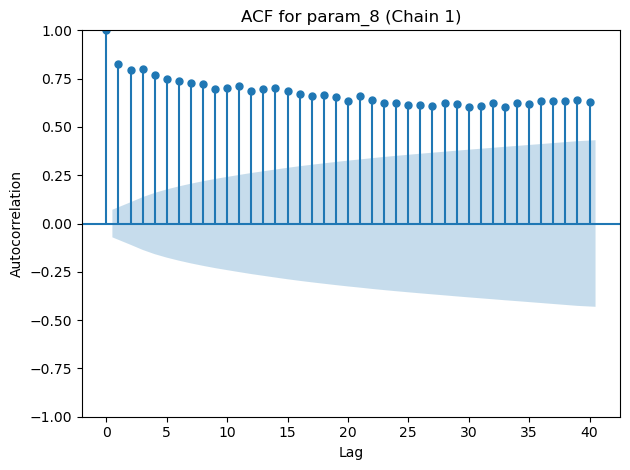

param_9: R-hat = 1.009, split R-hat = 1.812, ESS = 6.6


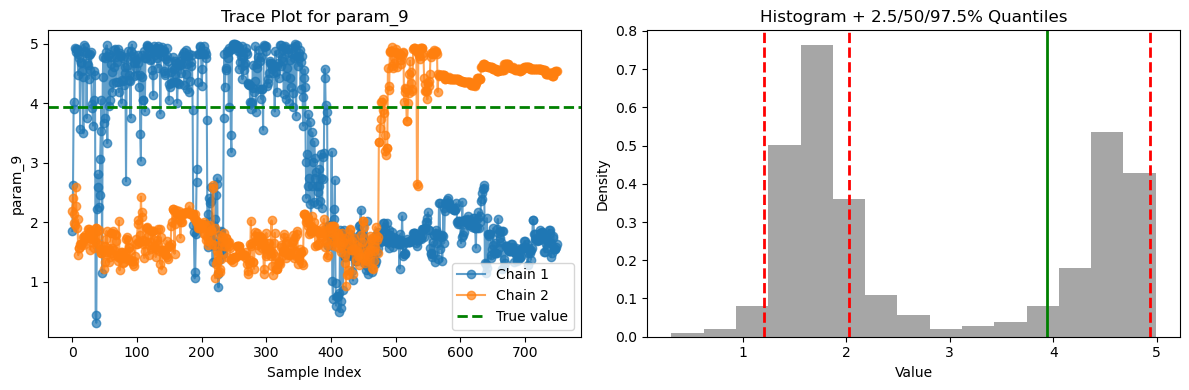

<Figure size 600x400 with 0 Axes>

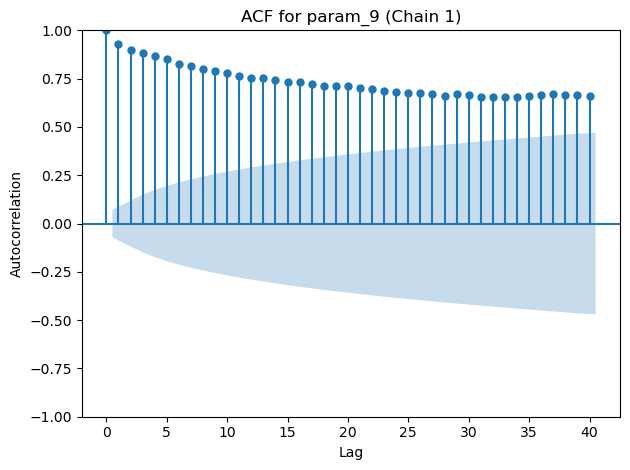

In [30]:
single_chain_samples = samples_1  # dict: param -> Tensor[n_samples]

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)

# 真实值
param_names = sorted(list(single_chain_samples.keys()))
true_params_tensor = test_x[34]
true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}

# 诊断和可视化
for param, samples_chains in mcmc_samples.items():
    true_value = true_params[param]
    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)
    plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()
    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')
    plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

# End